# Project CV - Pneumonia Detection

+ `Maximilian Mörth: if22b190`
+ `Alan Pisazka: if20b141`

DataSet: https://data.mendeley.com/datasets/rscbjbr9sj/3

## Dataset

>- How does the project relate to real applications?
>    - Pneumonia detection using computer vision has real-world applications in healthcare, particularly in radiology. It can assist radiologists and healthcare providers in quickly and accurately diagnosing pneumonia by analyzing chest X-rays or CT scans.
>    - The project can be used in hospitals and clinics to aid medical professionals in the triage of patients and can be part of telemedicine solutions for remote diagnosis.
>- Describe the dataset (Was it balanced? What was the imaging source? Etc.)
>- How does the project relate to real applications?
>- Which problems did you encounter and how did you solve them?
>- Describe what you did and why you did it!

## Practical Part

### Preparation

#### 0. Import Librarys

In [26]:
!pip install numpy torch matplotlib;


[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [28]:
data_dir = 'ZhangLabData/CellData/chest_xray/'

In [29]:
image_size = 224
batch_size = 32
num_epochs = 10

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [32]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['val'])

In [33]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

#### 1. Loading the Image Dataset

#### 2. Exploring the Data / Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

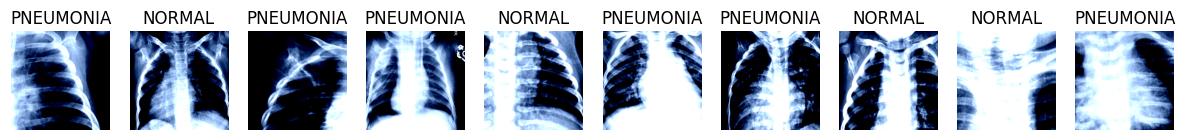

In [34]:
# Visualize some images
def show_images(data_loader, num_images):
    class_names = data_loader.dataset.classes
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for idx, ax in enumerate(axes):
        ax.imshow(images[idx].permute(1, 2, 0))
        ax.set_title(class_names[labels[idx]])
        ax.axis('off')

    plt.show()

show_images(train_loader, 10)  # Visualize training images

### Image Preprocessing

#### 1. Data Augmentation

#### 2. Train Test Split

### Model build/training

In [35]:
class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (image_size // 4) * (image_size // 4), 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * (image_size // 4) * (image_size // 4))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = PneumoniaCNN()
model = model.to(device)

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [37]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs to the same device as the model
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

Epoch 1, Loss: 0.5235080310120815
Epoch 2, Loss: 0.4548863829454271
Epoch 3, Loss: 0.423246558846497
Epoch 4, Loss: 0.390673164914294
Epoch 5, Loss: 0.37480007221059103
Epoch 6, Loss: 0.36537378399473863


KeyboardInterrupt: 

### Results / Discussion

In [38]:
model.eval()

PneumoniaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [39]:
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 86.86%


In [42]:
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(true_labels, predictions)


InvalidParameterError: The 'y_true' parameter of confusion_matrix must be an array-like. Got 542 instead.

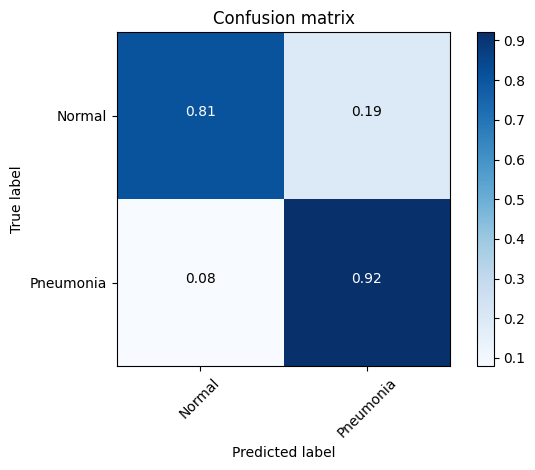

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, ['Normal', 'Pneumonia'], normalize=True)
plt.show()